## Leitura de imagens não usadas no treinamento para teste de resultado

#### Validação Multiclasse


In [1]:
import torch
from transformers import ViTForImageClassification
import pytorch_lightning as pl
import torch.nn as nn

import sys
import os

# dir_raiz = os.path.abspath(os.path.join(os.getcwd(), '..'))
# sys.path.append(dir_raiz)
from classes.modelo import Modelo
from classes.modelo_custom import ModeloCustom
from classes.modelo_binario import ModeloBin


import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

from classes.Validate import Validate

d:\AREA_DE_TRABALHO\Faculdade_8_Periodo\TCC\VIT-cric\vit-dynamic-patches\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
num_classes = 2
learning_rate = 0.0001

### Load Modelo Completo

In [ ]:
vl = Validate(num_class=num_classes, learning_rate=learning_rate, model_name="binario")

In [4]:
vl.load_default_model("models/modelo_vit_gpu.pth")

### Load Checkpoint

In [ ]:
vl.load_checkpoint_model('models/checkpoint/epoch=92-val_loss=0.33-val_accuracy=0.85.ckpt')

### Labels

In [4]:
labels = {'Negative for intraepithelial lesion': 0, 'Positive for intraepithelial lesion': 1}

In [6]:
labels = {'ASC-H': 0, 'ASC-US': 1, 'HSIL': 2, 'LSIL': 3, 'Negative for intraepithelial lesion': 4, 'SCC': 5}

### Avaliar pelo conjunto de Validação


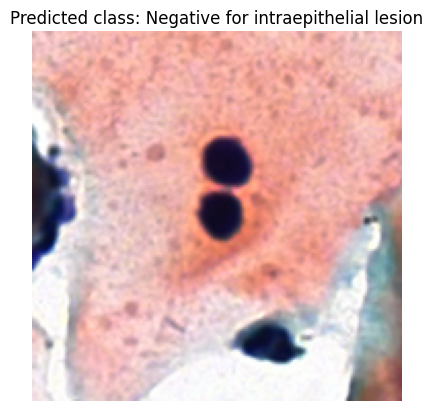

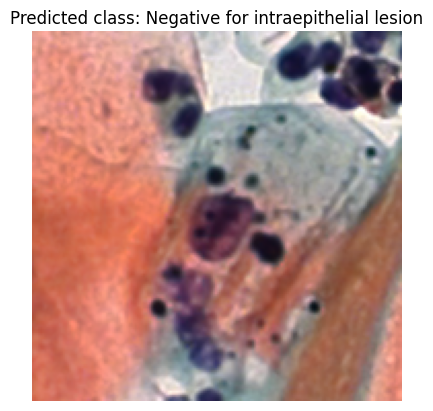

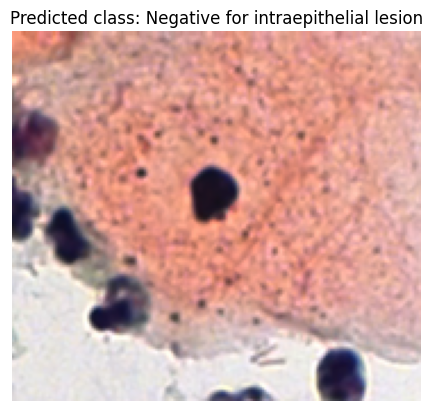

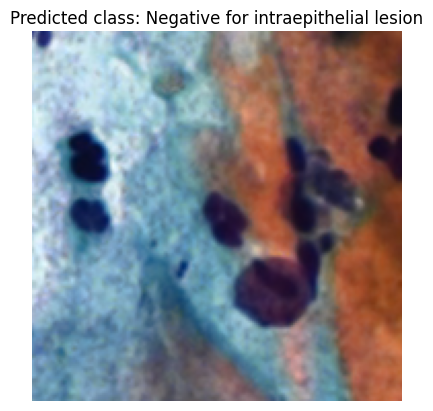

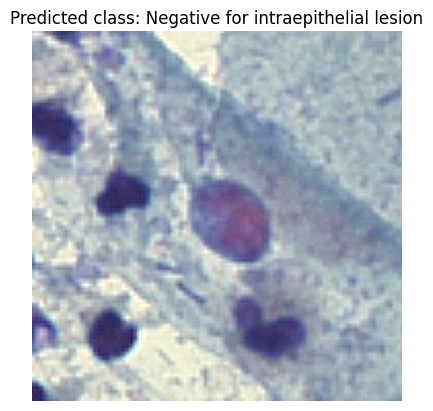

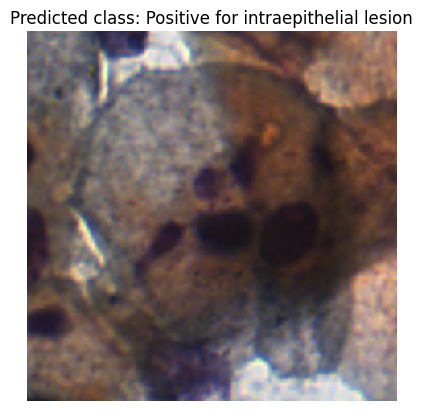

In [8]:
vl.validate_show("data/base_treinamento/validation/Negative for intraepithelial lesion", "binario", labels)

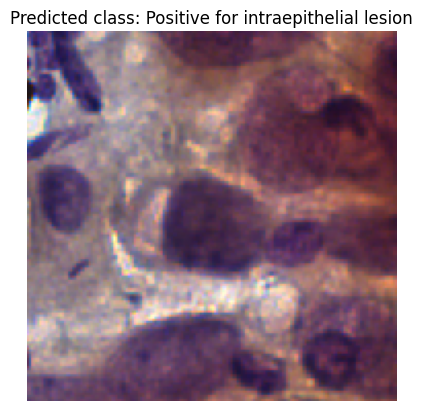

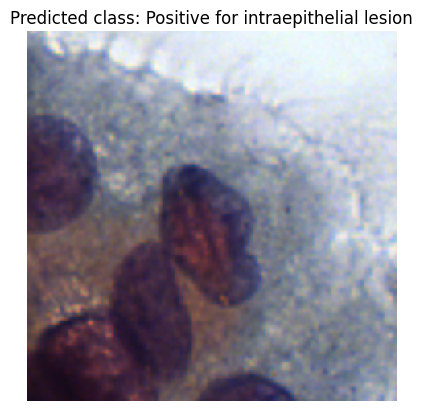

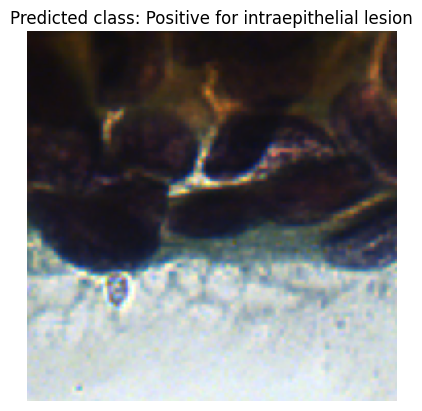

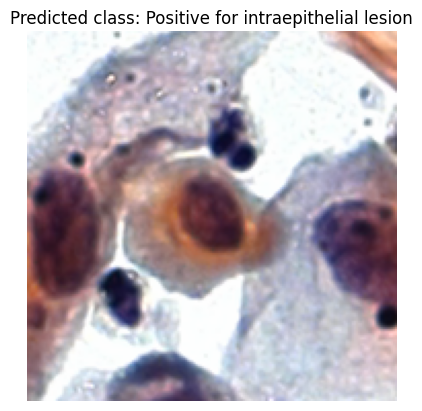

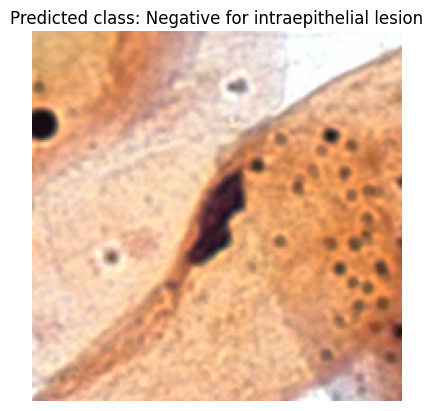

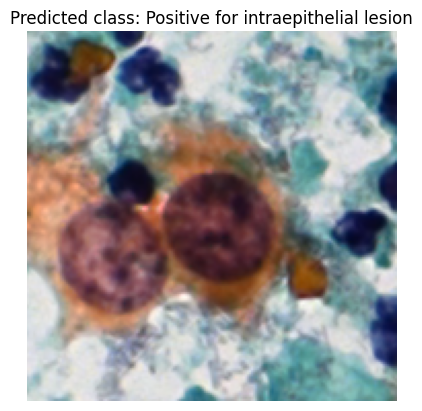

In [9]:
vl.validate_show("data/base_treinamento/validation/Positive for intraepithelial lesion", "binario", labels)

In [ ]:
vl.validate_show("data/base_treinamento/validate/ASC-H", "multiclass", labels)

In [ ]:
vl.validate_show("data/base_treinamento/validation/ASC-US","multiclass", labels)

In [ ]:
vl.validate_show("data/base_treinamento/validation/HSIL","multiclass", labels)

In [ ]:
vl.validate_show("data/base_treinamento/validation/LSIL","multiclass", labels)

In [ ]:
vl.validate_show("data/base_treinamento/validation/Negative for intraepithelial lesion","multiclass", labels)

In [ ]:
vl.validate_show("data/base_treinamento/validation/SCC","multiclass", labels)

### Avaliar pelo conjunto de Teste


### Binario

Processando imagens...: 1356 Imagens [01:20, 16.86 Imagens/s]
Processando imagens...: 1356 Imagens [01:19, 16.98 Imagens/s]
Processando imagens...: 951 Imagens [00:55, 17.23 Imagens/s]
Processando imagens...: 951 Imagens [00:54, 17.42 Imagens/s]


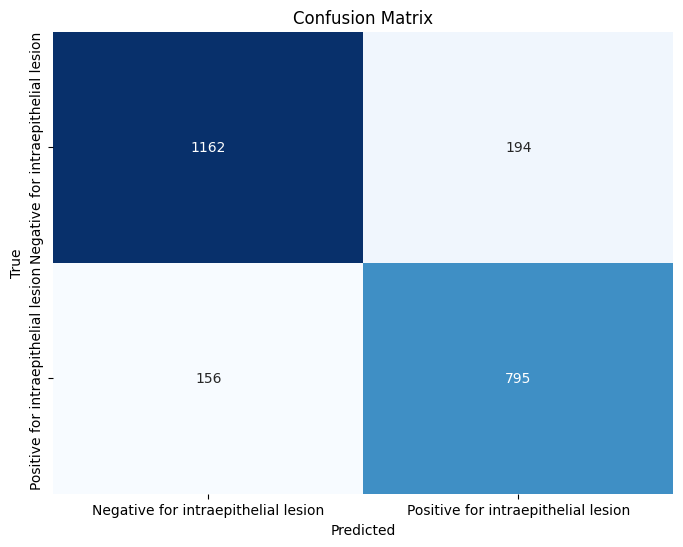

{'Negative for intraepithelial lesion': [1162, 194],
 'Positive for intraepithelial lesion': [156, 795]}

In [5]:
vl.load_default_model("models/modelo_vit_gpu.pth")
vl.generate_confusion_matrix(main_path="data/base_treinamento/test", labels=labels)


d:\AREA_DE_TRABALHO\Faculdade_8_Periodo\TCC\VIT-cric\vit-dynamic-patches\env\Lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of ViTModel were not initialized from the model checkpoint at WinKawaks/vit-tiny-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=192, out_features=192, bias=True)
              (key): Linear(in_features=192, out_features=192, bias=True)
              (value): Linear(in_features=192, out_features=192, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=192, out_features=192, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=1

Processando imagens...: 1356 Imagens [01:28, 15.35 Imagens/s]
Processando imagens...: 1356 Imagens [01:20, 16.94 Imagens/s]
Processando imagens...: 951 Imagens [00:56, 16.69 Imagens/s]
Processando imagens...: 951 Imagens [01:01, 15.56 Imagens/s]


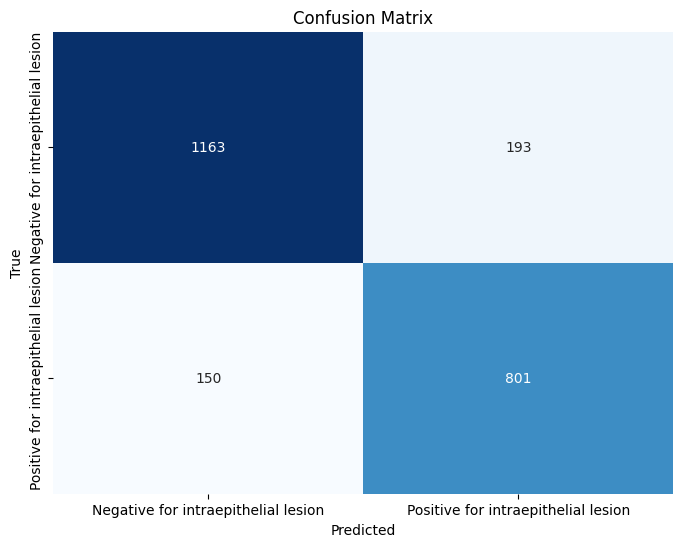

{'Negative for intraepithelial lesion': [1163, 193],
 'Positive for intraepithelial lesion': [150, 801]}

In [6]:
vl.load_checkpoint_model('models/checkpoint/epoch=92-val_loss=0.33-val_accuracy=0.85.ckpt')
vl.generate_confusion_matrix(main_path="data/base_treinamento/test", labels=labels)

In [10]:
negativa = []
positiva = []

In [11]:
value = vl.validate_qtd("data/base_treinamento/test/Negative for intraepithelial lesion", "Negative for intraepithelial lesion", "binario", labels)
value_s = value.split("/")
negativa.append( int(value_s[0]))
value

'1163/1356'

In [12]:
value = vl.validate_qtd("data/base_treinamento/test/Negative for intraepithelial lesion", "Positive for intraepithelial lesion", "binario", labels)
value_s = value.split("/")
negativa.append(int(value_s[0]))
value

'193/1356'

In [13]:
value = vl.validate_qtd("data/base_treinamento/test/Positive for intraepithelial lesion", "Negative for intraepithelial lesion", "binario", labels)
value_s = value.split("/")
positiva.append(int(value_s[0]))
value

'150/951'

In [14]:
value = vl.validate_qtd("data/base_treinamento/test/Positive for intraepithelial lesion", "Positive for intraepithelial lesion", "binario", labels)
value_s = value.split("/")
positiva.append(int(value_s[0]))
value

'801/951'

In [17]:
positiva, negativa

([150, 801], [1163, 193])

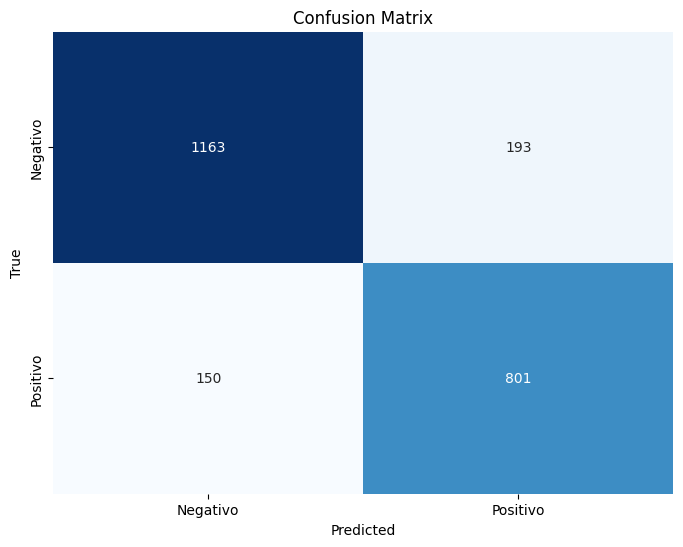

In [18]:
vl.plot_confusion_matrix([negativa, positiva], ['Negativo', 'Positivo'])

In [ ]:

# conf_matrix = np.array([
#   negativa,
#   positiva
# ])

# # Plotar a matriz de confusão
# plt.figure(figsize=(8, 6))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
#             xticklabels=['Negativo', 'Positivo'], yticklabels=['Negativo', 'Positivo'])
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.title('Confusion Matrix')
# plt.show()

### Multiclass

In [ ]:
vl.validate_qtd("data/base_treinamento/test/ASC-H", "ASC-H", "multiclass", labels)

In [ ]:
vl.validate_qtd("data/base_treinamento/test/ASC-US", "ASC-US", "multiclass", labels)

In [ ]:
vl.validate_qtd("data/base_treinamento/test/HSIL", "HSIL", "multiclass", labels)

In [ ]:
vl.validate_qtd("data/base_treinamento/test/LSIL", "LSIL", "multiclass", labels)

In [ ]:
vl.validate_qtd("data/base_treinamento/test/Negative for intraepithelial lesion", "Negative for intraepithelial lesion", "multiclass", labels)

In [ ]:
vl.validate_qtd("data/base_treinamento/test/SCC", "SCC", "multiclass", labels)

#### Confusion Matrix

In [ ]:


def calcular_matriz_confusao():

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])
    
    test_dataset = ImageFolder(root="data/base_treinamento/test/", transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            probabilities = torch.sigmoid(output)
            predicted = (probabilities > 0.5).int()
            

            all_preds.extend(predicted.cpu().numpy().flatten())
            all_labels.extend(labels.cpu().numpy().flatten())
    
    
    print(all_preds)            
    print(all_labels)            
    print(len(all_preds))            
    print(len(all_labels))            
    # Gerar a matriz de confusão
    conf_matrix = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    # plt.savefig(output_path)
    plt.show()
    
    # return conf_matrix
  
calcular_matriz_confusao()